# 4 Additional Functions with Keras 2

- 4.1 LSTM with MNIST
- 4.2 GAN with MNIST

## 4.1 LSTM with MNIST

### (1) 데이터셋

In [1]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
X_train_norm = X_train.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0
Y_train_onehot = utils.to_categorical(Y_train)
Y_test_onehot = utils.to_categorical(Y_test)

print(X_train_norm.shape, Y_train_onehot.shape)
n_in = X_train.shape[1:]
n_out = Y_train_onehot.shape[-1]

(60000, 28, 28) (60000, 10)


### (2) 모델링

In [3]:
def lstm(n_in, n_out):
    # Coding Time
    model = Sequential()
    model.add(LSTM(30, input_shape=n_in))
    model.add(Dense(n_out, activation='softmax'))
    return model

model = lstm(n_in, n_out)
model.summary()

2022-12-12 14:27:25.492036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 14:27:26.219844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22041 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                7080      
_________________________________________________________________
dense (Dense)                (None, 10)                310       
Total params: 7,390
Trainable params: 7,390
Non-trainable params: 0
_________________________________________________________________


### (3) 모델의 학습과정 설정

In [4]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
# Coding Time
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train_norm, Y_train_onehot, batch_size=128, epochs=50, validation_split=0.2, callbacks=[earlystopper])

2022-12-12 14:29:55.989334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-12 14:29:58.019763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


  1/375 [..............................] - ETA: 18:57 - loss: 2.3053 - accuracy: 0.0781

2022-12-12 14:29:58.911045: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


375/375 [==============================] - 6s 9ms/step - loss: 1.1485 - accuracy: 0.6456 - val_loss: 0.5744 - val_accuracy: 0.8366
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 0.4728 - accuracy: 0.8636 - val_loss: 0.3523 - val_accuracy: 0.8971
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.3268 - accuracy: 0.9040 - val_loss: 0.2692 - val_accuracy: 0.9194
Epoch 4/50
375/375 [==============================] - 3s 8ms/step - loss: 0.2626 - accuracy: 0.9227 - val_loss: 0.2249 - val_accuracy: 0.9335
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 0.2224 - accuracy: 0.9352 - val_loss: 0.2098 - val_accuracy: 0.9390
Epoch 6/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1914 - accuracy: 0.9441 - val_loss: 0.1700 - val_accuracy: 0.9484
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1707 - accuracy: 0.9506 - val_loss: 0.1678 - val_accuracy: 0.9502
Epoch 8/50
375/37

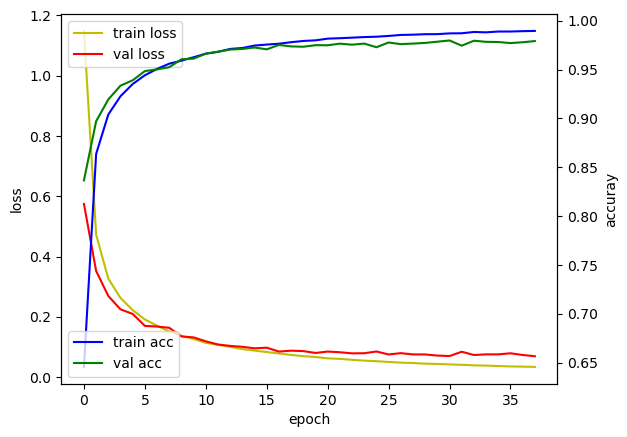

In [7]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [8]:
loss_and_accuracy = model.evaluate(X_test_norm, Y_test_onehot, batch_size=128, verbose=1)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

79/79 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9766
loss : 0.0840, accruracy : 0.9766


## 4.2 GAN with MNIST

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers

In [11]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

### (1) 데이터셋

In [12]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5 # -1~1 사이의 값
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test) # Label에 대한 진행이 없어도 됨

### (2-3) 모델링 / 모델 학습과정 설정

In [13]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [14]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # Coding Time
    discriminator.trainable = False
    
    gan_input = Input(shape=(random_dim,))
    
    x = generator(gan_input)
    
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [15]:
# 생성된 MNIST 이미지 출력
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### (4) 모델 학습

In [20]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져옵니다.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = x_train.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Coding Time
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0,1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            # Generator를 통해 MNIST 이미지를 생성
            generated_images = generator.predict(noise, verbose = 0)
            X = np.concatenate([image_batch, generated_images])
            
            # Discriminator 학습
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            # Generator 학습
            noise = np.random.normal(0,1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        # 20 epoch 마다 결과 확인
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)            
            

--------------- Epoch 1 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 15.08it/s]


--------------- Epoch 2 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.42it/s]


--------------- Epoch 3 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.50it/s]


--------------- Epoch 4 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.32it/s]


--------------- Epoch 5 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.21it/s]


--------------- Epoch 6 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.58it/s]


--------------- Epoch 7 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.49it/s]


--------------- Epoch 8 ---------------


100%|█████████████████████████████████████████| 468/468 [00:29<00:00, 15.61it/s]


--------------- Epoch 9 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.20it/s]


--------------- Epoch 10 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.52it/s]


--------------- Epoch 11 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.33it/s]


--------------- Epoch 12 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.37it/s]


--------------- Epoch 13 ---------------


100%|█████████████████████████████████████████| 468/468 [00:31<00:00, 14.86it/s]


--------------- Epoch 14 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.23it/s]


--------------- Epoch 15 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.58it/s]


--------------- Epoch 16 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.49it/s]


--------------- Epoch 17 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.39it/s]


--------------- Epoch 18 ---------------


100%|█████████████████████████████████████████| 468/468 [00:30<00:00, 15.20it/s]


--------------- Epoch 19 ---------------


100%|█████████████████████████████████████████| 468/468 [00:29<00:00, 15.81it/s]


--------------- Epoch 20 ---------------


100%|█████████████████████████████████████████| 468/468 [00:29<00:00, 15.64it/s]


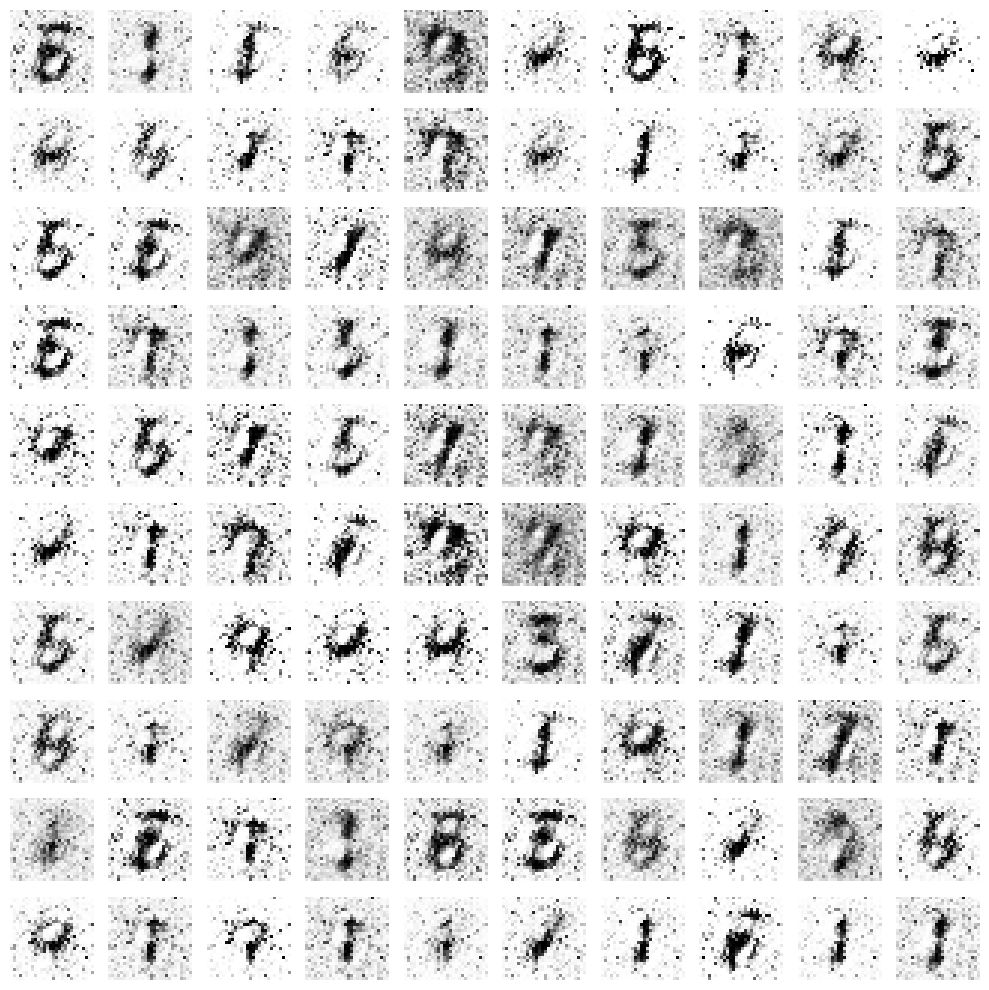

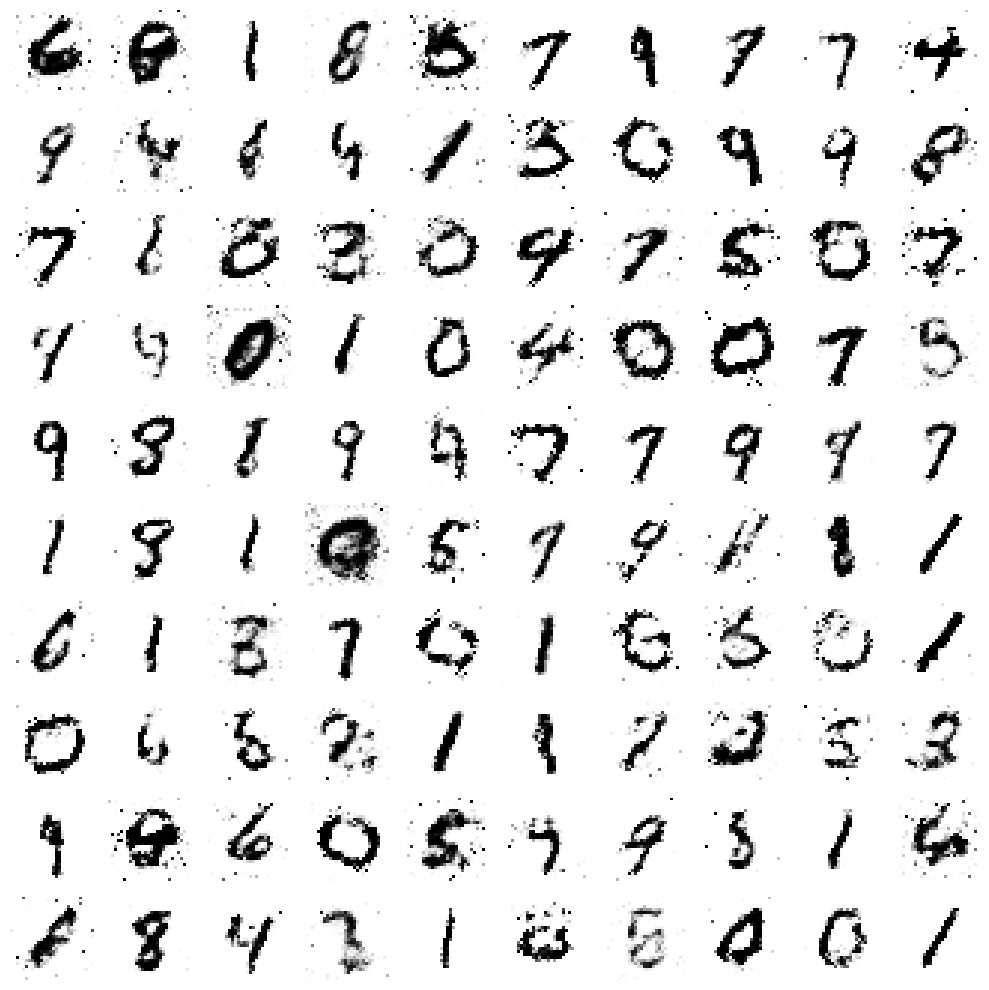

In [21]:
train(20, 128)